In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
img = plt.imread("/home/abhishar/Downloads/devnagri/vowels/1/001_01.jpg")

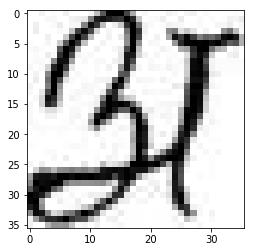

In [3]:
plt.imshow(img, "gray")

In [4]:
img.shape

(36, 36)

In [5]:
X = []
img_size = (32, 32)
DIR_PATH = "/home/abhishar/Downloads/devnagri/vowels/1/"
for img_path in os.listdir(DIR_PATH):
    img = plt.imread(DIR_PATH + img_path)
    X.append(cv2.resize(img, img_size))

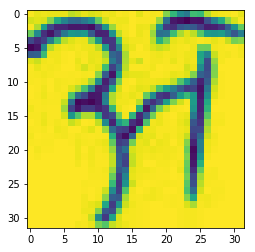

In [6]:
plt.imshow(X[0])

In [7]:
X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

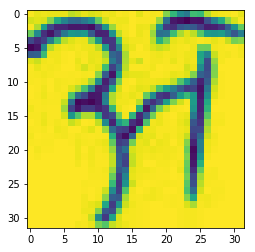

In [8]:
plt.imshow(X[0].reshape(32,32))

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, AveragePooling2D, Reshape
from tensorflow.nn import leaky_relu

In [10]:
from tensorflow.keras.backend import clear_session
clear_session()

In [11]:
discriminator = Sequential()
discriminator.add(Conv2D(32, (3, 3),input_shape=(img_size[0], img_size[1], 1), activation=leaky_relu, padding="same"))
discriminator.add(AveragePooling2D(padding="same"))
discriminator.add(Conv2D(64, (3, 3), activation=leaky_relu, padding="same"))
discriminator.add(AveragePooling2D(padding="same"))
discriminator.add(Conv2D(128, (3, 3), activation=leaky_relu, padding="same"))
discriminator.add(AveragePooling2D(padding="same"))
discriminator.add(Conv2D(128, (3, 3), activation=leaky_relu, padding="same"))
discriminator.add(AveragePooling2D(padding="same"))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

W0821 18:43:20.468016 140073035683648 deprecation.py:506] From /home/abhishar/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         1

In [13]:
latent_dim = 512

In [14]:
generator = Sequential()
generator.add(Dense(128 * img_size[0]//16 * img_size[0]//16, input_shape=(latent_dim,)))
generator.add(Reshape((img_size[0]//16, img_size[0]//16, 128)))
generator.add(Conv2DTranspose(128, (3, 3), padding="same", strides=2, activation="elu"))
generator.add(Conv2DTranspose(64, (3, 3), padding="same", strides=2, activation="elu"))
generator.add(Conv2DTranspose(32, (3, 3), padding="same", strides=2, activation="elu"))
generator.add(Conv2DTranspose(1, (3, 3), padding="same", strides=2, activation=None))

In [15]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 1)         289       
Total params: 502,785
Trainable params: 502,785
Non-trainable params: 0
________________________________________________

In [16]:
discriminator.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

z = Input((latent_dim, ))
fake_img = generator(z)


discriminator.trainable = False

dgz = discriminator(fake_img)

combined_model = Model(inputs=z, outputs=dgz)
combined_model.compile(loss="binary_crossentropy", optimizer="adam")

W0821 18:43:21.078531 140073035683648 deprecation.py:323] From /home/abhishar/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
def train(epochs, batch_size=128, show_every=100):

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        #  Training Discriminator
        idx = np.random.randint(0, X.shape[0], batch_size)
        imgs = X[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        
        #  Training Generator
        g_loss = combined_model.train_on_batch(noise, valid)

        print ("%d D loss: %f, acc.: %.2f | G loss: %f" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % show_every == 0:
            noise = np.random.normal(0, 1, (9, latent_dim))
            gen_imgs = generator.predict(noise)
            fig, ax = plt.subplots(3, 3)
            for i in range(3):
                for j in range(3):
                    ax[i,j].imshow(gen_imgs[i*3+j].reshape(32, 32), "gray")

W0821 18:43:52.415817 140073035683648 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0821 18:43:53.468031 140073035683648 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


0 D loss: 0.348892, acc.: 50.00 | G loss: 0.699283
1 D loss: 9.383395, acc.: 50.00 | G loss: 0.694736
2 D loss: 0.345771, acc.: 100.00 | G loss: 0.696738
3 D loss: 0.344192, acc.: 100.00 | G loss: 0.701037
4 D loss: 0.341670, acc.: 100.00 | G loss: 0.707051
5 D loss: 0.338560, acc.: 100.00 | G loss: 0.714426
6 D loss: 0.335032, acc.: 100.00 | G loss: 0.722880
7 D loss: 0.331161, acc.: 100.00 | G loss: 0.732183
8 D loss: 0.327749, acc.: 100.00 | G loss: 0.740906
9 D loss: 0.325336, acc.: 99.61 | G loss: 0.747732
10 D loss: 0.324657, acc.: 97.27 | G loss: 0.751324
11 D loss: 0.328412, acc.: 91.41 | G loss: 0.746722
12 D loss: 0.331859, acc.: 86.33 | G loss: 0.743270
13 D loss: 0.351247, acc.: 78.91 | G loss: 0.716591
14 D loss: 0.360511, acc.: 75.78 | G loss: 0.708410
15 D loss: 0.370594, acc.: 77.34 | G loss: 0.710529
16 D loss: 0.373670, acc.: 76.17 | G loss: 0.731030
17 D loss: 0.335681, acc.: 83.20 | G loss: 0.834790
18 D loss: 0.266267, acc.: 96.48 | G loss: 1.069114
19 D loss: 2.88

157 D loss: 0.056319, acc.: 100.00 | G loss: 2.772389
158 D loss: 0.059590, acc.: 100.00 | G loss: 2.626507
159 D loss: 0.065769, acc.: 100.00 | G loss: 2.528236
160 D loss: 0.071959, acc.: 100.00 | G loss: 2.492186
161 D loss: 0.070904, acc.: 100.00 | G loss: 2.601457
162 D loss: 0.070665, acc.: 100.00 | G loss: 2.596818
163 D loss: 0.073034, acc.: 99.22 | G loss: 2.687722
164 D loss: 0.150215, acc.: 95.70 | G loss: 1.888186
165 D loss: 0.214984, acc.: 91.41 | G loss: 1.656500
166 D loss: 0.140040, acc.: 94.53 | G loss: 2.324761
167 D loss: 0.131555, acc.: 95.70 | G loss: 2.656842
168 D loss: 0.376501, acc.: 81.64 | G loss: 1.046325
169 D loss: 0.624748, acc.: 66.80 | G loss: 0.762313
170 D loss: 0.394839, acc.: 80.08 | G loss: 1.659885
171 D loss: 0.074944, acc.: 99.61 | G loss: 3.517846
172 D loss: 0.814356, acc.: 65.62 | G loss: 0.534085
173 D loss: 1.129643, acc.: 57.03 | G loss: 0.271654
174 D loss: 1.084678, acc.: 51.17 | G loss: 0.317044
175 D loss: 0.635078, acc.: 58.98 | G lo

311 D loss: 0.022442, acc.: 100.00 | G loss: 4.666334
312 D loss: 0.058034, acc.: 98.44 | G loss: 4.261692
313 D loss: 0.026623, acc.: 100.00 | G loss: 3.838993
314 D loss: 0.036905, acc.: 99.22 | G loss: 3.926178
315 D loss: 0.027592, acc.: 100.00 | G loss: 4.564141
316 D loss: 0.020815, acc.: 100.00 | G loss: 5.231696
317 D loss: 0.069482, acc.: 98.83 | G loss: 3.803934
318 D loss: 0.087545, acc.: 97.66 | G loss: 3.866449
319 D loss: 0.057741, acc.: 100.00 | G loss: 4.679703
320 D loss: 1.341224, acc.: 47.27 | G loss: 1.220793
321 D loss: 0.081481, acc.: 99.22 | G loss: 5.543712
322 D loss: 2.347845, acc.: 17.58 | G loss: 0.045117
323 D loss: 2.398777, acc.: 50.00 | G loss: 0.063938
324 D loss: 1.262011, acc.: 50.39 | G loss: 0.513389
325 D loss: 0.168181, acc.: 98.83 | G loss: 2.861513
326 D loss: 0.135288, acc.: 97.66 | G loss: 4.977003
327 D loss: 0.826826, acc.: 62.11 | G loss: 2.876081
328 D loss: 0.199071, acc.: 95.31 | G loss: 1.299497
329 D loss: 0.324971, acc.: 82.42 | G los

465 D loss: 0.203748, acc.: 91.02 | G loss: 6.224844
466 D loss: 0.097695, acc.: 97.27 | G loss: 4.386115
467 D loss: 0.126730, acc.: 95.70 | G loss: 3.763319
468 D loss: 0.082100, acc.: 96.88 | G loss: 5.042349
469 D loss: 0.052649, acc.: 98.05 | G loss: 6.675089
470 D loss: 0.079106, acc.: 97.66 | G loss: 6.146986
471 D loss: 0.079269, acc.: 96.09 | G loss: 5.091879
472 D loss: 0.072052, acc.: 98.44 | G loss: 4.769470
473 D loss: 0.078201, acc.: 97.27 | G loss: 4.916808
474 D loss: 0.060570, acc.: 97.66 | G loss: 5.252364
475 D loss: 0.097321, acc.: 96.88 | G loss: 4.450959
476 D loss: 0.207062, acc.: 92.19 | G loss: 4.153856
477 D loss: 0.079207, acc.: 97.27 | G loss: 5.171408
478 D loss: 0.315805, acc.: 87.89 | G loss: 2.762275
479 D loss: 0.146526, acc.: 92.58 | G loss: 4.263955
480 D loss: 0.017588, acc.: 100.00 | G loss: 7.470245
481 D loss: 0.231212, acc.: 91.80 | G loss: 3.410089
482 D loss: 0.143156, acc.: 94.92 | G loss: 2.718592
483 D loss: 0.068662, acc.: 99.22 | G loss: 4

619 D loss: 0.108735, acc.: 96.48 | G loss: 3.143843
620 D loss: 0.086748, acc.: 98.83 | G loss: 3.387044
621 D loss: 0.036766, acc.: 100.00 | G loss: 4.484622
622 D loss: 0.090946, acc.: 96.48 | G loss: 4.224165
623 D loss: 0.061923, acc.: 98.44 | G loss: 3.797295
624 D loss: 0.069399, acc.: 98.44 | G loss: 3.594646
625 D loss: 0.082902, acc.: 97.66 | G loss: 4.174170
626 D loss: 0.040898, acc.: 100.00 | G loss: 5.179357
627 D loss: 0.129716, acc.: 95.31 | G loss: 3.738285
628 D loss: 0.091947, acc.: 98.44 | G loss: 3.562912
629 D loss: 0.052016, acc.: 99.22 | G loss: 4.906089
630 D loss: 0.045358, acc.: 98.83 | G loss: 5.856713
631 D loss: 0.152583, acc.: 94.53 | G loss: 3.575050
632 D loss: 0.116131, acc.: 96.09 | G loss: 3.407567
633 D loss: 0.063513, acc.: 98.05 | G loss: 5.001406
634 D loss: 0.016225, acc.: 99.61 | G loss: 6.954973
635 D loss: 0.156918, acc.: 94.53 | G loss: 3.213713
636 D loss: 0.154778, acc.: 91.41 | G loss: 2.537457
637 D loss: 0.092318, acc.: 97.27 | G loss: 

773 D loss: 0.037513, acc.: 99.61 | G loss: 4.757350
774 D loss: 0.061570, acc.: 98.05 | G loss: 4.353876
775 D loss: 0.082752, acc.: 97.27 | G loss: 4.648454
776 D loss: 0.110052, acc.: 96.09 | G loss: 3.933116
777 D loss: 0.066505, acc.: 97.27 | G loss: 4.694233
778 D loss: 0.050196, acc.: 98.83 | G loss: 5.106994
779 D loss: 0.100325, acc.: 96.48 | G loss: 4.480813
780 D loss: 0.083737, acc.: 97.66 | G loss: 4.099164
781 D loss: 0.068546, acc.: 98.44 | G loss: 4.436674
782 D loss: 0.094971, acc.: 96.88 | G loss: 4.328565
783 D loss: 0.069434, acc.: 99.22 | G loss: 4.205046
784 D loss: 0.084149, acc.: 98.44 | G loss: 3.775753
785 D loss: 0.077464, acc.: 98.44 | G loss: 3.740475
786 D loss: 0.031308, acc.: 99.61 | G loss: 4.137435
787 D loss: 0.028185, acc.: 99.22 | G loss: 4.392428
788 D loss: 0.027594, acc.: 98.83 | G loss: 4.563187
789 D loss: 0.026633, acc.: 99.61 | G loss: 4.378472
790 D loss: 0.021661, acc.: 99.22 | G loss: 5.043532
791 D loss: 0.014497, acc.: 100.00 | G loss: 5

928 D loss: 0.106480, acc.: 99.61 | G loss: 2.106529
929 D loss: 0.088956, acc.: 100.00 | G loss: 2.314654
930 D loss: 0.107333, acc.: 99.22 | G loss: 2.236912
931 D loss: 0.095443, acc.: 99.61 | G loss: 2.513618
932 D loss: 0.093532, acc.: 98.44 | G loss: 2.557054
933 D loss: 0.105785, acc.: 98.05 | G loss: 2.385097
934 D loss: 0.089743, acc.: 99.22 | G loss: 2.364424
935 D loss: 0.087604, acc.: 99.61 | G loss: 2.316601
936 D loss: 0.076479, acc.: 100.00 | G loss: 2.505433
937 D loss: 0.075709, acc.: 100.00 | G loss: 2.574402
938 D loss: 0.084562, acc.: 100.00 | G loss: 2.502657
939 D loss: 0.096623, acc.: 99.61 | G loss: 2.323806
940 D loss: 0.083066, acc.: 100.00 | G loss: 2.355418
941 D loss: 0.067234, acc.: 100.00 | G loss: 2.678737
942 D loss: 0.089691, acc.: 98.05 | G loss: 2.557467
943 D loss: 0.069260, acc.: 99.22 | G loss: 2.564862
944 D loss: 0.080989, acc.: 100.00 | G loss: 2.499911
945 D loss: 0.064603, acc.: 100.00 | G loss: 2.672403
946 D loss: 0.071987, acc.: 99.61 | G 

1081 D loss: 0.178510, acc.: 93.36 | G loss: 1.917048
1082 D loss: 0.152875, acc.: 94.92 | G loss: 2.109707
1083 D loss: 0.134400, acc.: 96.48 | G loss: 2.499685
1084 D loss: 0.194479, acc.: 95.31 | G loss: 2.426141
1085 D loss: 0.152351, acc.: 95.70 | G loss: 2.306370
1086 D loss: 0.149961, acc.: 95.31 | G loss: 2.151286
1087 D loss: 0.116456, acc.: 98.05 | G loss: 2.339569
1088 D loss: 0.089035, acc.: 98.83 | G loss: 2.819109
1089 D loss: 0.063280, acc.: 99.22 | G loss: 3.344668
1090 D loss: 0.088727, acc.: 98.83 | G loss: 3.137583
1091 D loss: 0.054263, acc.: 100.00 | G loss: 3.117645
1092 D loss: 0.041865, acc.: 100.00 | G loss: 3.228601
1093 D loss: 0.035675, acc.: 100.00 | G loss: 3.285528
1094 D loss: 0.028075, acc.: 100.00 | G loss: 3.798724
1095 D loss: 0.022119, acc.: 100.00 | G loss: 4.129265
1096 D loss: 0.017447, acc.: 100.00 | G loss: 4.428027
1097 D loss: 0.016500, acc.: 100.00 | G loss: 4.693164
1098 D loss: 0.021514, acc.: 100.00 | G loss: 4.508214
1099 D loss: 0.01557

1232 D loss: 0.083215, acc.: 99.22 | G loss: 3.097388
1233 D loss: 0.041799, acc.: 99.22 | G loss: 3.761762
1234 D loss: 0.135989, acc.: 94.92 | G loss: 3.339538
1235 D loss: 0.081056, acc.: 98.44 | G loss: 2.627245
1236 D loss: 0.091025, acc.: 98.83 | G loss: 2.405371
1237 D loss: 0.083307, acc.: 99.61 | G loss: 2.579385
1238 D loss: 0.065232, acc.: 99.61 | G loss: 3.004783
1239 D loss: 0.062647, acc.: 98.83 | G loss: 3.337946
1240 D loss: 0.095452, acc.: 97.27 | G loss: 2.964425
1241 D loss: 0.067964, acc.: 99.22 | G loss: 2.827514
1242 D loss: 0.078304, acc.: 99.61 | G loss: 2.816676
1243 D loss: 0.106208, acc.: 97.27 | G loss: 2.663728
1244 D loss: 0.094050, acc.: 98.44 | G loss: 2.584719
1245 D loss: 0.088982, acc.: 98.44 | G loss: 2.836821
1246 D loss: 0.084670, acc.: 99.61 | G loss: 2.838999
1247 D loss: 0.102962, acc.: 98.83 | G loss: 2.627614
1248 D loss: 0.088196, acc.: 99.22 | G loss: 2.619130
1249 D loss: 0.085673, acc.: 99.22 | G loss: 2.761158
1250 D loss: 0.076401, acc.:

1383 D loss: 0.248609, acc.: 90.62 | G loss: 1.927561
1384 D loss: 0.287219, acc.: 87.11 | G loss: 2.049698
1385 D loss: 0.118387, acc.: 96.88 | G loss: 2.944541
1386 D loss: 0.189248, acc.: 94.53 | G loss: 3.242357
1387 D loss: 0.245522, acc.: 92.58 | G loss: 2.802723
1388 D loss: 0.193567, acc.: 95.31 | G loss: 2.159242
1389 D loss: 0.202778, acc.: 93.75 | G loss: 1.957624
1390 D loss: 0.141238, acc.: 98.05 | G loss: 2.502208
1391 D loss: 0.106968, acc.: 99.22 | G loss: 3.206456
1392 D loss: 0.134611, acc.: 96.09 | G loss: 3.409564
1393 D loss: 0.114819, acc.: 97.27 | G loss: 2.991268
1394 D loss: 0.087399, acc.: 98.83 | G loss: 2.851804
1395 D loss: 0.155312, acc.: 96.48 | G loss: 2.634032
1396 D loss: 0.109849, acc.: 98.83 | G loss: 2.743932
1397 D loss: 0.100735, acc.: 97.66 | G loss: 3.226574
1398 D loss: 0.080769, acc.: 99.61 | G loss: 3.289680
1399 D loss: 0.096108, acc.: 98.44 | G loss: 3.632829
1400 D loss: 0.088661, acc.: 98.44 | G loss: 3.597765
1401 D loss: 0.103732, acc.:

1534 D loss: 0.022827, acc.: 100.00 | G loss: 4.499304
1535 D loss: 0.023778, acc.: 100.00 | G loss: 4.211265
1536 D loss: 0.028616, acc.: 99.61 | G loss: 4.140201
1537 D loss: 0.023697, acc.: 100.00 | G loss: 4.676538
1538 D loss: 0.064673, acc.: 99.22 | G loss: 3.823770
1539 D loss: 0.030675, acc.: 100.00 | G loss: 5.480008
1540 D loss: 0.148354, acc.: 94.92 | G loss: 3.437893
1541 D loss: 0.020333, acc.: 100.00 | G loss: 5.871887
1542 D loss: 0.108269, acc.: 96.09 | G loss: 3.055316
1543 D loss: 0.068243, acc.: 99.22 | G loss: 5.939096
1544 D loss: 0.032414, acc.: 98.83 | G loss: 6.080564
1545 D loss: 0.019180, acc.: 100.00 | G loss: 4.734747
1546 D loss: 0.018761, acc.: 100.00 | G loss: 5.084333
1547 D loss: 0.009034, acc.: 100.00 | G loss: 6.549718
1548 D loss: 0.007483, acc.: 100.00 | G loss: 7.213027
1549 D loss: 0.028291, acc.: 99.22 | G loss: 4.832330
1550 D loss: 0.024803, acc.: 100.00 | G loss: 4.940466
1551 D loss: 0.008937, acc.: 100.00 | G loss: 6.565754
1552 D loss: 0.01

1685 D loss: 0.181343, acc.: 94.14 | G loss: 14.352142
1686 D loss: 0.103269, acc.: 95.70 | G loss: 14.933386
1687 D loss: 0.071347, acc.: 96.88 | G loss: 14.467046
1688 D loss: 0.017993, acc.: 99.61 | G loss: 15.083361
1689 D loss: 0.047157, acc.: 98.44 | G loss: 12.368954
1690 D loss: 0.057139, acc.: 98.05 | G loss: 9.243152
1691 D loss: 0.050829, acc.: 98.44 | G loss: 6.951884
1692 D loss: 0.023993, acc.: 100.00 | G loss: 7.009722
1693 D loss: 0.011051, acc.: 100.00 | G loss: 6.903483
1694 D loss: 0.013108, acc.: 99.61 | G loss: 6.948720
1695 D loss: 0.010195, acc.: 99.61 | G loss: 6.944125
1696 D loss: 0.024189, acc.: 98.83 | G loss: 6.116693
1697 D loss: 0.021362, acc.: 100.00 | G loss: 5.401959
1698 D loss: 0.024064, acc.: 100.00 | G loss: 5.471231
1699 D loss: 0.020882, acc.: 100.00 | G loss: 6.356200
1700 D loss: 0.009139, acc.: 100.00 | G loss: 7.010169
1701 D loss: 0.016135, acc.: 99.61 | G loss: 7.174413
1702 D loss: 0.047458, acc.: 98.44 | G loss: 5.075139
1703 D loss: 0.03

1836 D loss: 0.013696, acc.: 100.00 | G loss: 4.691290
1837 D loss: 0.035397, acc.: 98.83 | G loss: 4.026126
1838 D loss: 0.026720, acc.: 100.00 | G loss: 3.972888
1839 D loss: 0.022246, acc.: 100.00 | G loss: 4.438894
1840 D loss: 0.020808, acc.: 100.00 | G loss: 4.641277
1841 D loss: 0.066073, acc.: 97.66 | G loss: 3.058570
1842 D loss: 0.062496, acc.: 99.22 | G loss: 4.078927
1843 D loss: 0.006556, acc.: 100.00 | G loss: 6.506766
1844 D loss: 1.406979, acc.: 43.36 | G loss: 0.339973
1845 D loss: 1.092440, acc.: 54.69 | G loss: 1.694407
1846 D loss: 0.026237, acc.: 100.00 | G loss: 5.299105
1847 D loss: 0.169559, acc.: 93.75 | G loss: 5.900486
1848 D loss: 0.281770, acc.: 87.50 | G loss: 3.423619
1849 D loss: 0.068713, acc.: 99.61 | G loss: 2.240346
1850 D loss: 0.124404, acc.: 96.88 | G loss: 1.908865
1851 D loss: 0.200009, acc.: 90.23 | G loss: 1.716017
1852 D loss: 0.155596, acc.: 94.53 | G loss: 2.085342
1853 D loss: 0.101564, acc.: 96.88 | G loss: 2.704181
1854 D loss: 0.043212,

1987 D loss: 0.067112, acc.: 98.05 | G loss: 5.026663
1988 D loss: 0.063848, acc.: 98.44 | G loss: 4.591431
1989 D loss: 0.045100, acc.: 98.83 | G loss: 4.419663
1990 D loss: 0.015547, acc.: 100.00 | G loss: 4.804003
1991 D loss: 0.019957, acc.: 100.00 | G loss: 4.894446
1992 D loss: 0.047171, acc.: 98.44 | G loss: 4.455021
1993 D loss: 0.038468, acc.: 99.61 | G loss: 4.174675
1994 D loss: 0.029274, acc.: 99.22 | G loss: 4.365108
1995 D loss: 0.014932, acc.: 100.00 | G loss: 4.924627
1996 D loss: 0.009038, acc.: 100.00 | G loss: 5.451978
1997 D loss: 0.022601, acc.: 98.83 | G loss: 4.926287
1998 D loss: 0.053816, acc.: 99.22 | G loss: 3.798218
1999 D loss: 0.058503, acc.: 99.22 | G loss: 3.909186
2000 D loss: 0.013810, acc.: 100.00 | G loss: 5.329537


/home/abhishar/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2001 D loss: 0.015778, acc.: 99.22 | G loss: 6.046175
2002 D loss: 0.052292, acc.: 98.44 | G loss: 4.588567
2003 D loss: 0.073986, acc.: 98.83 | G loss: 3.471562
2004 D loss: 0.026716, acc.: 99.61 | G loss: 4.367482
2005 D loss: 0.012749, acc.: 100.00 | G loss: 5.265957
2006 D loss: 0.008618, acc.: 100.00 | G loss: 6.203238
2007 D loss: 0.158580, acc.: 96.48 | G loss: 2.160566
2008 D loss: 0.403338, acc.: 81.25 | G loss: 6.921278
2009 D loss: 0.087935, acc.: 97.66 | G loss: 12.625297
2010 D loss: 5.580462, acc.: 8.20 | G loss: 0.110474
2011 D loss: 2.699565, acc.: 52.34 | G loss: 1.592778
2012 D loss: 0.119187, acc.: 92.97 | G loss: 6.324899
2013 D loss: 0.700436, acc.: 87.11 | G loss: 6.117244
2014 D loss: 0.760444, acc.: 85.55 | G loss: 3.064269
2015 D loss: 0.163225, acc.: 94.92 | G loss: 2.069503
2016 D loss: 0.151390, acc.: 99.61 | G loss: 1.592283
2017 D loss: 0.175920, acc.: 96.48 | G loss: 1.654643
2018 D loss: 0.163943, acc.: 97.27 | G loss: 1.929890
2019 D loss: 0.109145, acc

2153 D loss: 0.043476, acc.: 98.44 | G loss: 7.967216
2154 D loss: 0.021924, acc.: 99.61 | G loss: 6.650465
2155 D loss: 0.038908, acc.: 98.83 | G loss: 6.042383
2156 D loss: 0.040799, acc.: 99.61 | G loss: 5.148166
2157 D loss: 0.044786, acc.: 99.61 | G loss: 5.021762
2158 D loss: 0.038646, acc.: 99.22 | G loss: 5.343380
2159 D loss: 0.041748, acc.: 100.00 | G loss: 4.832661
2160 D loss: 0.033045, acc.: 100.00 | G loss: 5.516027
2161 D loss: 0.025299, acc.: 100.00 | G loss: 5.951754
2162 D loss: 0.051445, acc.: 99.61 | G loss: 5.716628
2163 D loss: 0.059645, acc.: 97.66 | G loss: 4.818980
2164 D loss: 0.055681, acc.: 99.22 | G loss: 4.290500
2165 D loss: 0.078650, acc.: 98.05 | G loss: 4.386262
2166 D loss: 0.077152, acc.: 98.05 | G loss: 4.279687
2167 D loss: 0.046743, acc.: 99.22 | G loss: 5.079971
2168 D loss: 0.062081, acc.: 98.05 | G loss: 5.304416
2169 D loss: 0.112687, acc.: 98.05 | G loss: 4.242816
2170 D loss: 0.057519, acc.: 98.83 | G loss: 4.337750
2171 D loss: 0.066970, ac

2304 D loss: 0.058079, acc.: 98.05 | G loss: 5.273850
2305 D loss: 0.077656, acc.: 98.05 | G loss: 4.282367
2306 D loss: 0.058590, acc.: 99.61 | G loss: 4.906140
2307 D loss: 0.056878, acc.: 99.22 | G loss: 5.437227
2308 D loss: 0.048057, acc.: 99.61 | G loss: 5.367282
2309 D loss: 0.038811, acc.: 99.61 | G loss: 5.269940
2310 D loss: 0.030841, acc.: 100.00 | G loss: 5.016100
2311 D loss: 0.042110, acc.: 99.22 | G loss: 4.781071
2312 D loss: 0.027663, acc.: 100.00 | G loss: 4.862298
2313 D loss: 0.035686, acc.: 98.83 | G loss: 4.690897
2314 D loss: 0.023879, acc.: 100.00 | G loss: 5.010090
2315 D loss: 0.017340, acc.: 100.00 | G loss: 4.823215
2316 D loss: 0.016617, acc.: 100.00 | G loss: 5.040493
2317 D loss: 0.030416, acc.: 99.61 | G loss: 4.876529
2318 D loss: 0.024973, acc.: 99.61 | G loss: 4.924777
2319 D loss: 0.028006, acc.: 100.00 | G loss: 4.781076
2320 D loss: 0.021190, acc.: 100.00 | G loss: 4.612183
2321 D loss: 0.026166, acc.: 100.00 | G loss: 4.811004
2322 D loss: 0.01719

2455 D loss: 0.057926, acc.: 98.83 | G loss: 5.104151
2456 D loss: 0.093346, acc.: 96.48 | G loss: 4.959098
2457 D loss: 0.032909, acc.: 98.83 | G loss: 5.782999
2458 D loss: 0.018509, acc.: 99.61 | G loss: 7.086487
2459 D loss: 0.022058, acc.: 99.61 | G loss: 7.338715
2460 D loss: 0.041286, acc.: 98.83 | G loss: 5.853946
2461 D loss: 0.045817, acc.: 98.83 | G loss: 4.888651
2462 D loss: 0.045939, acc.: 98.83 | G loss: 4.953434
2463 D loss: 0.016083, acc.: 99.61 | G loss: 6.127011
2464 D loss: 0.034167, acc.: 99.22 | G loss: 5.896345
2465 D loss: 0.090976, acc.: 96.88 | G loss: 4.732687
2466 D loss: 0.035386, acc.: 99.22 | G loss: 5.357465
2467 D loss: 0.091602, acc.: 96.09 | G loss: 5.158143
2468 D loss: 0.081750, acc.: 98.05 | G loss: 5.641462
2469 D loss: 0.018847, acc.: 99.61 | G loss: 6.686399
2470 D loss: 0.045288, acc.: 98.44 | G loss: 5.462389
2471 D loss: 0.044254, acc.: 98.83 | G loss: 5.423748
2472 D loss: 0.040934, acc.: 98.44 | G loss: 6.640728
2473 D loss: 0.018900, acc.:

2606 D loss: 0.016057, acc.: 99.61 | G loss: 5.960068
2607 D loss: 0.029553, acc.: 99.22 | G loss: 5.334050
2608 D loss: 0.016732, acc.: 100.00 | G loss: 5.863825
2609 D loss: 0.023862, acc.: 99.22 | G loss: 6.147631
2610 D loss: 0.021899, acc.: 99.61 | G loss: 6.014732
2611 D loss: 0.026101, acc.: 99.22 | G loss: 5.755494
2612 D loss: 0.033723, acc.: 99.61 | G loss: 5.533184
2613 D loss: 0.019590, acc.: 99.61 | G loss: 6.388114
2614 D loss: 0.028536, acc.: 98.83 | G loss: 6.026116
2615 D loss: 0.022680, acc.: 100.00 | G loss: 5.465218
2616 D loss: 0.028154, acc.: 99.61 | G loss: 5.469758
2617 D loss: 0.009974, acc.: 100.00 | G loss: 6.584546
2618 D loss: 0.016874, acc.: 99.61 | G loss: 6.803565
2619 D loss: 0.018375, acc.: 99.61 | G loss: 6.014689
2620 D loss: 0.026179, acc.: 100.00 | G loss: 5.374038
2621 D loss: 0.022488, acc.: 100.00 | G loss: 5.941564
2622 D loss: 0.013949, acc.: 99.61 | G loss: 6.725059
2623 D loss: 0.013380, acc.: 100.00 | G loss: 6.692860
2624 D loss: 0.022877,

2757 D loss: 0.019074, acc.: 100.00 | G loss: 5.880356
2758 D loss: 0.018232, acc.: 99.61 | G loss: 6.538921
2759 D loss: 0.016528, acc.: 100.00 | G loss: 6.744006
2760 D loss: 0.012115, acc.: 100.00 | G loss: 7.025347
2761 D loss: 0.016279, acc.: 100.00 | G loss: 6.740815
2762 D loss: 0.015360, acc.: 100.00 | G loss: 6.761398
2763 D loss: 0.016455, acc.: 99.61 | G loss: 6.840189
2764 D loss: 0.012386, acc.: 100.00 | G loss: 6.927799
2765 D loss: 0.020856, acc.: 100.00 | G loss: 6.309857
2766 D loss: 0.015395, acc.: 100.00 | G loss: 6.711037
2767 D loss: 0.017963, acc.: 100.00 | G loss: 6.783168
2768 D loss: 0.026023, acc.: 99.61 | G loss: 7.381452
2769 D loss: 0.032411, acc.: 99.22 | G loss: 6.778326
2770 D loss: 0.062996, acc.: 98.44 | G loss: 5.928428
2771 D loss: 0.016512, acc.: 100.00 | G loss: 6.778478
2772 D loss: 0.019101, acc.: 99.22 | G loss: 6.826924
2773 D loss: 0.013800, acc.: 100.00 | G loss: 7.347419
2774 D loss: 0.009847, acc.: 100.00 | G loss: 7.154061
2775 D loss: 0.0

2908 D loss: 0.361657, acc.: 92.97 | G loss: 6.206903
2909 D loss: 0.284974, acc.: 88.67 | G loss: 5.110501
2910 D loss: 0.050697, acc.: 97.66 | G loss: 9.990009
2911 D loss: 0.001223, acc.: 100.00 | G loss: 14.977358
2912 D loss: 0.000084, acc.: 100.00 | G loss: 19.422276
2913 D loss: 0.063720, acc.: 98.83 | G loss: 20.057953
2914 D loss: 0.143568, acc.: 97.27 | G loss: 10.555014
2915 D loss: 0.041094, acc.: 99.61 | G loss: 6.787624
2916 D loss: 0.182273, acc.: 91.80 | G loss: 4.923294
2917 D loss: 0.062852, acc.: 97.27 | G loss: 6.647620
2918 D loss: 0.044107, acc.: 98.83 | G loss: 8.849958
2919 D loss: 0.046678, acc.: 98.83 | G loss: 10.311160
2920 D loss: 0.254748, acc.: 93.75 | G loss: 4.506862
2921 D loss: 0.439794, acc.: 80.86 | G loss: 9.655590
2922 D loss: 0.003868, acc.: 100.00 | G loss: 24.418785
2923 D loss: 1.038173, acc.: 76.95 | G loss: 4.467564
2924 D loss: 1.279700, acc.: 67.19 | G loss: 2.359681
2925 D loss: 0.474589, acc.: 84.77 | G loss: 7.098893
2926 D loss: 0.0118

3058 D loss: 0.008208, acc.: 100.00 | G loss: 6.891051
3059 D loss: 0.005211, acc.: 100.00 | G loss: 6.510724
3060 D loss: 0.008730, acc.: 100.00 | G loss: 6.755904
3061 D loss: 0.003221, acc.: 100.00 | G loss: 7.868550
3062 D loss: 0.006470, acc.: 100.00 | G loss: 8.190833
3063 D loss: 0.009252, acc.: 100.00 | G loss: 6.819229
3064 D loss: 0.015107, acc.: 100.00 | G loss: 7.314480
3065 D loss: 0.003241, acc.: 100.00 | G loss: 9.490170
3066 D loss: 0.025410, acc.: 98.44 | G loss: 6.085942
3067 D loss: 0.025331, acc.: 100.00 | G loss: 7.917498
3068 D loss: 0.002677, acc.: 100.00 | G loss: 13.040430
3069 D loss: 0.044254, acc.: 98.44 | G loss: 10.485034
3070 D loss: 0.037670, acc.: 98.83 | G loss: 3.362627
3071 D loss: 0.496777, acc.: 77.34 | G loss: 41.372566
3072 D loss: 5.162400, acc.: 53.52 | G loss: 0.021562
3073 D loss: 5.474629, acc.: 50.00 | G loss: 3.503453
3074 D loss: 0.016905, acc.: 98.83 | G loss: 24.843132
3075 D loss: 0.199602, acc.: 94.92 | G loss: 42.852840
3076 D loss: 

3209 D loss: 0.043372, acc.: 99.22 | G loss: 4.752235
3210 D loss: 0.057682, acc.: 98.83 | G loss: 4.809902
3211 D loss: 0.041477, acc.: 98.44 | G loss: 5.331877
3212 D loss: 0.027555, acc.: 99.22 | G loss: 5.591315
3213 D loss: 0.022869, acc.: 99.22 | G loss: 6.670088
3214 D loss: 0.016911, acc.: 99.22 | G loss: 6.974227
3215 D loss: 0.027519, acc.: 98.83 | G loss: 7.397693
3216 D loss: 0.016581, acc.: 99.61 | G loss: 6.909029
3217 D loss: 0.039152, acc.: 97.66 | G loss: 6.581291
3218 D loss: 0.025303, acc.: 100.00 | G loss: 6.391577
3219 D loss: 0.051401, acc.: 98.44 | G loss: 5.785045
3220 D loss: 0.038404, acc.: 98.44 | G loss: 7.555287
3221 D loss: 0.036744, acc.: 98.83 | G loss: 8.474457
3222 D loss: 0.048768, acc.: 97.66 | G loss: 8.192429
3223 D loss: 0.080724, acc.: 96.09 | G loss: 6.981171
3224 D loss: 0.073980, acc.: 96.88 | G loss: 6.235255
3225 D loss: 0.045319, acc.: 98.05 | G loss: 7.096992
3226 D loss: 0.016930, acc.: 99.22 | G loss: 8.804325
3227 D loss: 0.053812, acc.

3360 D loss: 0.021735, acc.: 99.61 | G loss: 5.277225
3361 D loss: 0.027082, acc.: 99.22 | G loss: 4.776334
3362 D loss: 0.019419, acc.: 100.00 | G loss: 5.177815
3363 D loss: 0.012894, acc.: 100.00 | G loss: 6.051555
3364 D loss: 0.017708, acc.: 99.61 | G loss: 6.530209
3365 D loss: 0.030396, acc.: 99.22 | G loss: 5.468851
3366 D loss: 0.015540, acc.: 100.00 | G loss: 4.927813
3367 D loss: 0.016194, acc.: 100.00 | G loss: 5.135077
3368 D loss: 0.014674, acc.: 100.00 | G loss: 5.585344
3369 D loss: 0.010077, acc.: 100.00 | G loss: 6.301146
3370 D loss: 0.020580, acc.: 99.61 | G loss: 6.155192
3371 D loss: 0.020788, acc.: 99.61 | G loss: 5.373328
3372 D loss: 0.032011, acc.: 99.22 | G loss: 5.227402
3373 D loss: 0.030708, acc.: 99.22 | G loss: 5.628434
3374 D loss: 0.013952, acc.: 100.00 | G loss: 5.969661
3375 D loss: 0.028295, acc.: 99.61 | G loss: 5.190826
3376 D loss: 0.016592, acc.: 99.61 | G loss: 5.261892
3377 D loss: 0.010762, acc.: 100.00 | G loss: 6.288168
3378 D loss: 0.00821

3511 D loss: 0.055879, acc.: 98.83 | G loss: 3.658049
3512 D loss: 0.044861, acc.: 99.22 | G loss: 4.065501
3513 D loss: 0.037688, acc.: 99.22 | G loss: 4.398491
3514 D loss: 0.028408, acc.: 100.00 | G loss: 4.650971
3515 D loss: 0.032690, acc.: 99.61 | G loss: 4.606871
3516 D loss: 0.038306, acc.: 99.22 | G loss: 4.451954
3517 D loss: 0.020531, acc.: 100.00 | G loss: 4.406098
3518 D loss: 0.031187, acc.: 99.61 | G loss: 4.361815
3519 D loss: 0.029563, acc.: 99.61 | G loss: 4.516979
3520 D loss: 0.037061, acc.: 99.22 | G loss: 4.456430
3521 D loss: 0.036135, acc.: 99.61 | G loss: 4.078771
3522 D loss: 0.021053, acc.: 100.00 | G loss: 4.640434
3523 D loss: 0.040844, acc.: 98.05 | G loss: 4.577418
3524 D loss: 0.031060, acc.: 99.22 | G loss: 4.423144
3525 D loss: 0.023678, acc.: 99.22 | G loss: 4.913373
3526 D loss: 0.014770, acc.: 99.61 | G loss: 5.250554
3527 D loss: 0.012665, acc.: 99.61 | G loss: 5.424272
3528 D loss: 0.011862, acc.: 99.61 | G loss: 5.536850
3529 D loss: 0.016504, ac

3661 D loss: 0.016459, acc.: 100.00 | G loss: 7.242476
3662 D loss: 0.022497, acc.: 99.22 | G loss: 7.442675
3663 D loss: 0.036568, acc.: 98.44 | G loss: 6.654034
3664 D loss: 0.012608, acc.: 100.00 | G loss: 7.364886
3665 D loss: 0.010555, acc.: 100.00 | G loss: 7.455710
3666 D loss: 0.010453, acc.: 100.00 | G loss: 7.470171
3667 D loss: 0.017274, acc.: 99.61 | G loss: 6.659543
3668 D loss: 0.006636, acc.: 100.00 | G loss: 6.541358
3669 D loss: 0.010462, acc.: 100.00 | G loss: 6.013541
3670 D loss: 0.008724, acc.: 100.00 | G loss: 6.282859
3671 D loss: 0.016113, acc.: 99.61 | G loss: 6.213535
3672 D loss: 0.011131, acc.: 100.00 | G loss: 5.906069
3673 D loss: 0.014110, acc.: 100.00 | G loss: 5.641571
3674 D loss: 0.010083, acc.: 100.00 | G loss: 6.093818
3675 D loss: 0.012842, acc.: 100.00 | G loss: 6.598939
3676 D loss: 0.045246, acc.: 99.22 | G loss: 5.058659
3677 D loss: 0.045692, acc.: 99.22 | G loss: 5.782349
3678 D loss: 0.006858, acc.: 100.00 | G loss: 8.199537
3679 D loss: 0.0

3812 D loss: 0.011254, acc.: 100.00 | G loss: 5.342051
3813 D loss: 0.011148, acc.: 100.00 | G loss: 5.601340
3814 D loss: 0.006326, acc.: 100.00 | G loss: 5.874027
3815 D loss: 0.015973, acc.: 100.00 | G loss: 5.740687
3816 D loss: 0.013792, acc.: 99.61 | G loss: 5.298184
3817 D loss: 0.013850, acc.: 100.00 | G loss: 5.123604
3818 D loss: 0.023170, acc.: 100.00 | G loss: 4.901574
3819 D loss: 0.011361, acc.: 100.00 | G loss: 5.509425
3820 D loss: 0.007468, acc.: 100.00 | G loss: 6.102446
3821 D loss: 0.013577, acc.: 99.61 | G loss: 5.819355
3822 D loss: 0.008208, acc.: 100.00 | G loss: 5.716630
3823 D loss: 0.015463, acc.: 99.61 | G loss: 5.193811
3824 D loss: 0.013015, acc.: 100.00 | G loss: 5.186560
3825 D loss: 0.013782, acc.: 100.00 | G loss: 5.469707
3826 D loss: 0.019559, acc.: 99.22 | G loss: 5.618131
3827 D loss: 0.013230, acc.: 100.00 | G loss: 5.557250
3828 D loss: 0.050127, acc.: 98.83 | G loss: 4.519095
3829 D loss: 0.022720, acc.: 100.00 | G loss: 5.031511
3830 D loss: 0.

3963 D loss: 0.018843, acc.: 99.61 | G loss: 6.239848
3964 D loss: 0.009883, acc.: 100.00 | G loss: 7.361346
3965 D loss: 0.020046, acc.: 99.61 | G loss: 7.182562
3966 D loss: 0.024314, acc.: 99.61 | G loss: 7.176336
3967 D loss: 0.029127, acc.: 98.83 | G loss: 6.582177
3968 D loss: 0.007361, acc.: 100.00 | G loss: 6.981654
3969 D loss: 0.036157, acc.: 98.83 | G loss: 7.163737
3970 D loss: 0.005984, acc.: 100.00 | G loss: 8.727585
3971 D loss: 0.010082, acc.: 100.00 | G loss: 9.207680
3972 D loss: 0.045656, acc.: 99.22 | G loss: 8.122031
3973 D loss: 0.021285, acc.: 99.22 | G loss: 6.796005
3974 D loss: 0.039991, acc.: 98.44 | G loss: 6.596426
3975 D loss: 0.019670, acc.: 99.22 | G loss: 7.759706
3976 D loss: 0.004330, acc.: 100.00 | G loss: 8.780554
3977 D loss: 0.010851, acc.: 99.22 | G loss: 9.029109
3978 D loss: 0.013544, acc.: 99.22 | G loss: 8.680880
3979 D loss: 0.019999, acc.: 98.83 | G loss: 7.174283
3980 D loss: 0.037264, acc.: 99.22 | G loss: 6.650657
3981 D loss: 0.017401, 

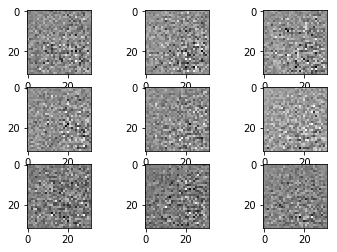

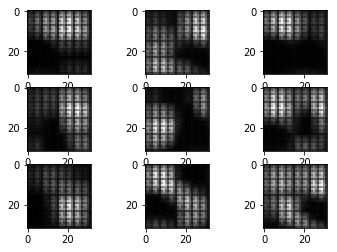

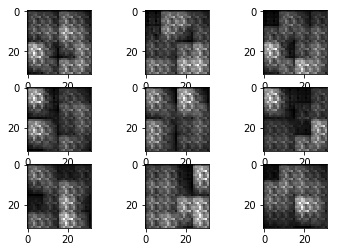

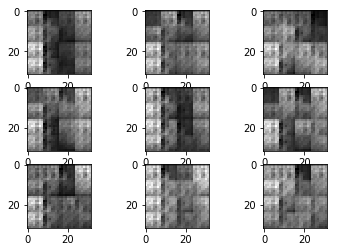

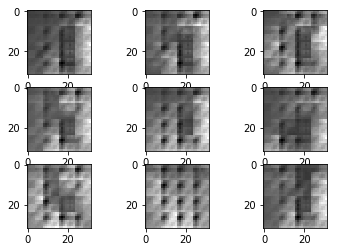

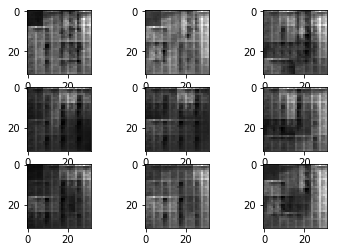

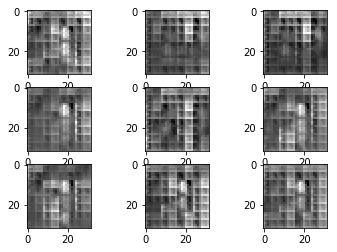

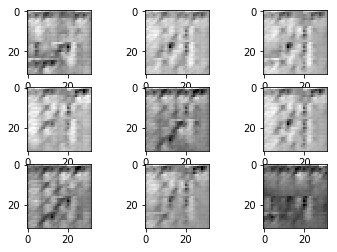

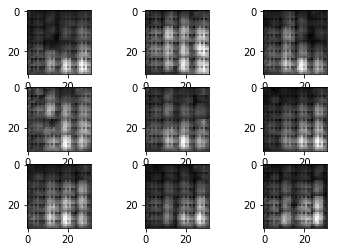

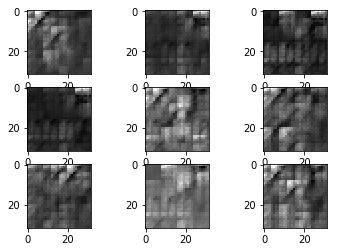

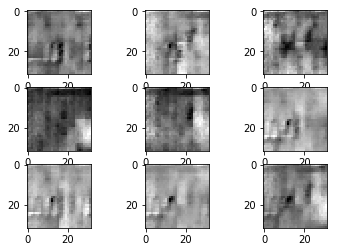

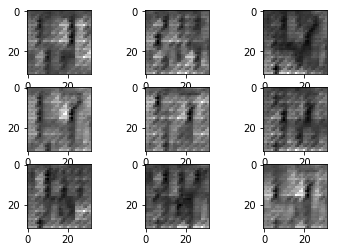

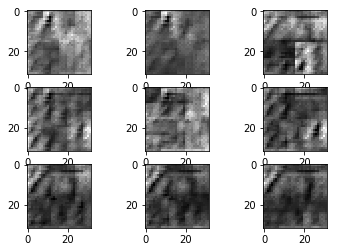

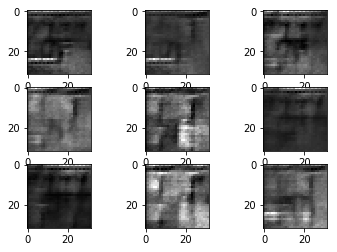

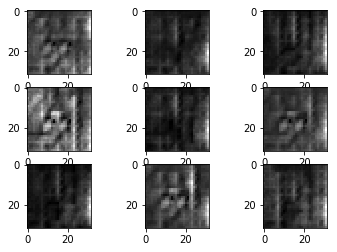

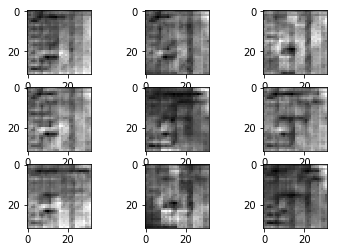

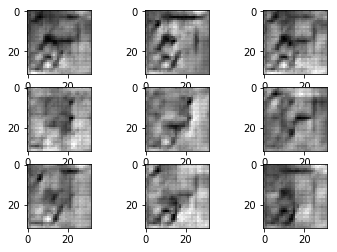

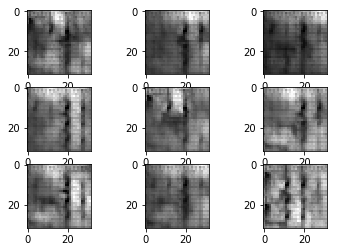

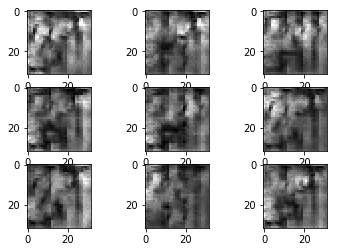

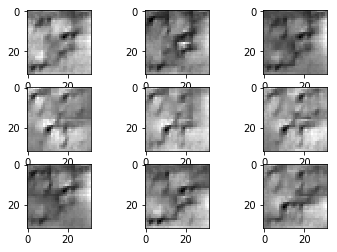

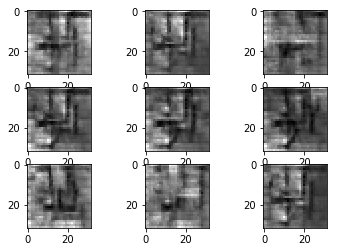

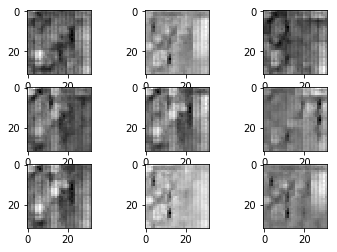

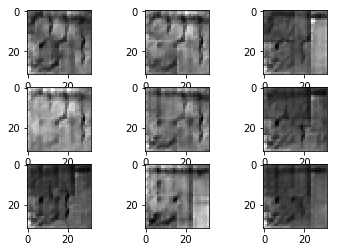

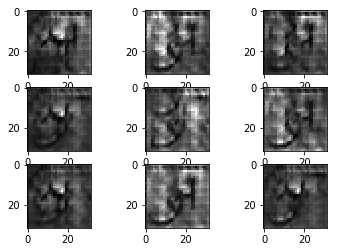

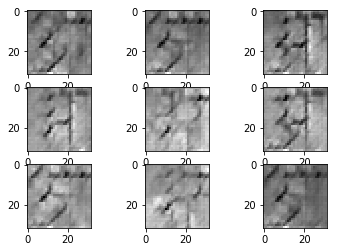

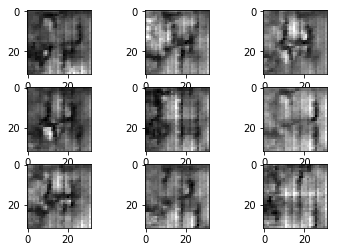

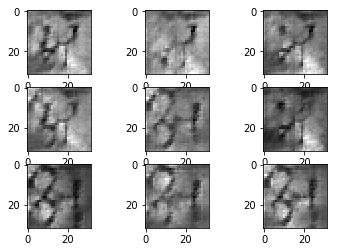

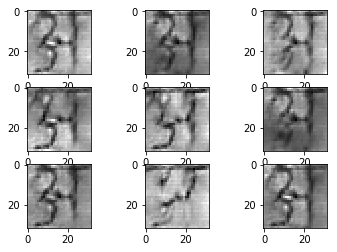

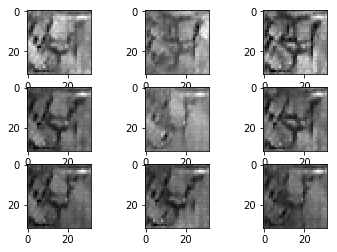

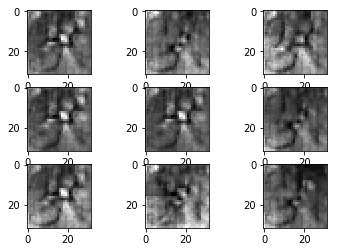

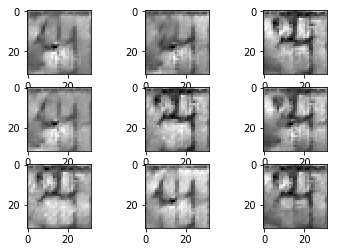

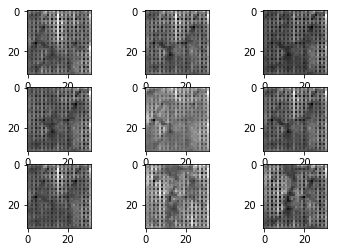

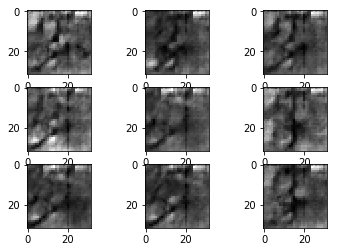

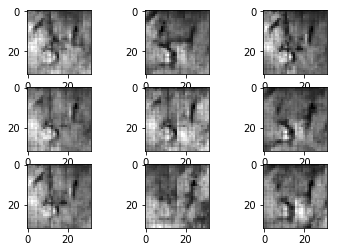

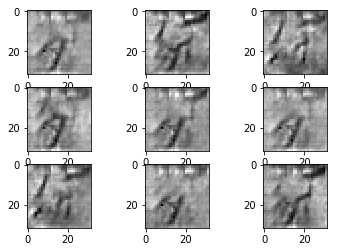

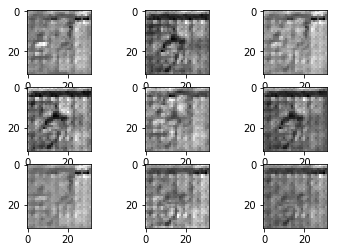

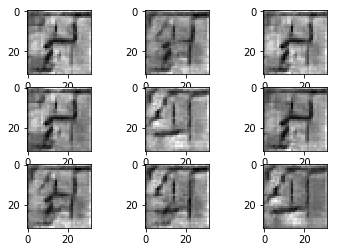

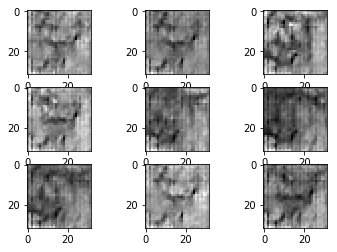

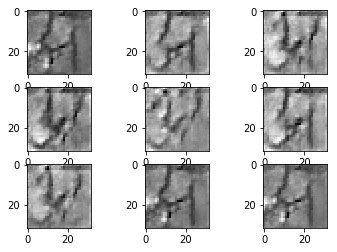

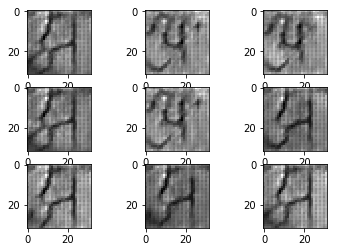

In [18]:
train(4000)

# Generated Images

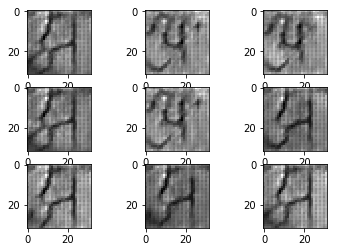